In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 19a

## Simple RNN


<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Lets import some libraries
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf

%matplotlib inline

In [3]:
# Some basic parameters

inpDir = '../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

EPOCHS = 20  # number of cycles to run

ALPHA = 0.1  # learning rate

TEST_SIZE = 0.2 # What fraction we want to keep for testing

BATCH_SIZE = 32

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (12,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }
CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Function

In [4]:
def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    ax = axes[0]

    hist_df.plot(y = ['loss','val_loss'], ax = ax, colormap=CMAP)

    lossmin = hist_df['loss'].min()

    testmin = hist_df['val_loss'].min()

    # little beautification
    txtstr = "Min Loss: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(lossmin,
                                                                            testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel("Loss")

    ax.grid();

    ax = axes[1]

    hist_df.plot( y = ['rmse', 'val_rmse'], ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df['rmse'].min()
    testmin = hist_df['val_rmse'].min()
    txtstr = "Min RMS: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(accmin,
                                                                                testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel("mean_squared_error")
    ax.grid();
    plt.tight_layout()

## Load Weather Data
Source: [Kaggle](https://www.kaggle.com/muthuj7/weather-dataset)

In [5]:
dataFilename = 'weatherHistory.csv'
data_df = pd.read_csv(os.path.join(inpDir, dataFilename))
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [6]:
data_df.shape

(96453, 12)

In [7]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], utc=True)

In [8]:
temp_df = data_df[['datetime', 'Temperature (C)']]
temp_df = temp_df.sort_values('datetime', axis=0, ascending=True)
temp_df = temp_df.reset_index(drop=True)
temp_df.head()

,datetime,Temperature (C)
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [9]:
temp_df = temp_df.rename({'Temperature (C)': 'temp'}, axis=1)
temp_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [10]:
# comment uncomment following lines if you want part or full dataset

startDate = pd.to_datetime('2007-1-1', utc=True)
endDate = pd.to_datetime('2008-1-1', utc=True)
#temp_df = temp_df[(temp_df['datetime']  >= startDate) & (temp_df['datetime']  < endDate)]

In [11]:
temp_df.reset_index(drop=True, inplace = True)
temp_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [12]:
temp_df.shape

(96453, 2)

## Plotting samples

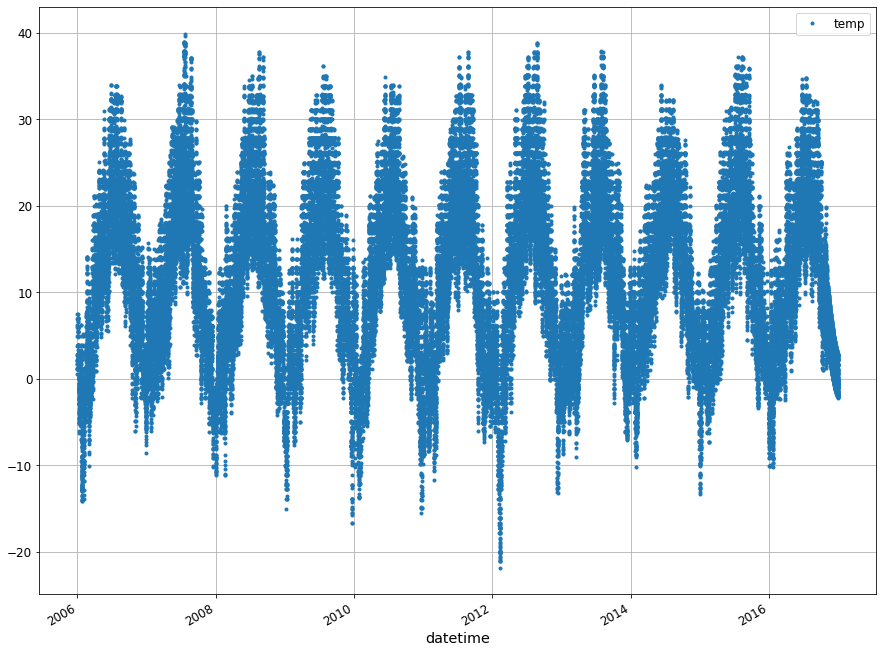

In [13]:
fig, ax = plt.subplots(figsize = (15,12))
temp_df.plot(x='datetime', y='temp', style=".", ax = ax);
ax.grid()

In [14]:
h_units = 100
input_shape = (1, 10000)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(units = h_units, input_shape = input_shape, activation = 'tanh', ))
model.add(tf.keras.layers.Dense(1, activation = 'linear', ))

2022-06-14 14:08:16.584208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 14:08:16.604323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 14:08:16.604640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 14:08:16.605216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [15]:
wax = model.get_weights()[0].shape
waa = model.get_weights()[1].shape
baa = model.get_weights()[2].shape
way = model.get_weights()[3].shape
bay = model.get_weights()[4].shape

print ('Shape of Matrix:')
print ('Wax = ', wax,'; Waa = ', waa, '; baa = ', baa,'; Way = ', way,'; bay = ', bay)

Shape of Matrix:
Wax =  (10000, 100) ; Waa =  (100, 100) ; baa =  (100,) ; Way =  (100, 1) ; bay =  (1,)


In [16]:
time_step = 24

In [17]:
y_idx = np.arange(time_step, temp_df.shape[0], time_step)
y_df = temp_df.iloc[y_idx]
y_df.head()

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [18]:
y_df.shape, len(y_df)*time_step

((4018, 2), 96432)

In [19]:
temp_df.shape

(96453, 2)

In [20]:
X_df = temp_df.iloc[range(len(y_df) * time_step)]

In [21]:
X_df['temp'].values.shape

(96432,)

In [22]:
X = np.reshape(X_df['temp'].values, (y_df.shape[0], time_step))
X.shape

(4018, 24)

In [23]:
X = X[:, :23]
X.shape

(4018, 23)

In [24]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [25]:
split = int(y_df.shape[0] * (1-TEST_SIZE))
X_train = X[:split]
X_test = X[split:]
y_train = y_df['temp'].values[:split]
y_test = y_df['temp'].values[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((3214, 23, 1), (804, 23, 1), (3214,), (804,))

In [26]:
h_units = 64
input_shape=(time_step-1, 1 ) # we are using one feature only.

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(units = h_units, input_shape = input_shape, activation = 'tanh'))
model.add(tf.keras.layers.Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [27]:
history = model.fit(X_train, y_train,
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test),
                    batch_size= BATCH_SIZE, 
                    verbose=1)

Epoch 1/20
 15/101 [===>..........................] - ETA: 1s - loss: 114.4811 - root_mean_squared_error: 10.6996

2022-06-14 14:08:18.935947: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


101/101 [==============================] - 3s 13ms/step - loss: 49.5601 - root_mean_squared_error: 7.0399 - val_loss: 9.6865 - val_root_mean_squared_error: 3.1123
Epoch 2/20
101/101 [==============================] - 1s 11ms/step - loss: 10.2807 - root_mean_squared_error: 3.2064 - val_loss: 3.8035 - val_root_mean_squared_error: 1.9502
Epoch 3/20
101/101 [==============================] - 1s 13ms/step - loss: 4.9946 - root_mean_squared_error: 2.2349 - val_loss: 2.0521 - val_root_mean_squared_error: 1.4325
Epoch 4/20
101/101 [==============================] - 1s 12ms/step - loss: 3.0360 - root_mean_squared_error: 1.7424 - val_loss: 1.2581 - val_root_mean_squared_error: 1.1217
Epoch 5/20
101/101 [==============================] - 1s 12ms/step - loss: 2.1559 - root_mean_squared_error: 1.4683 - val_loss: 0.9763 - val_root_mean_squared_error: 0.9881
Epoch 6/20
101/101 [==============================] - 1s 12ms/step - loss: 1.7403 - root_mean_squared_error: 1.3192 - val_loss: 0.8422 - val_roo

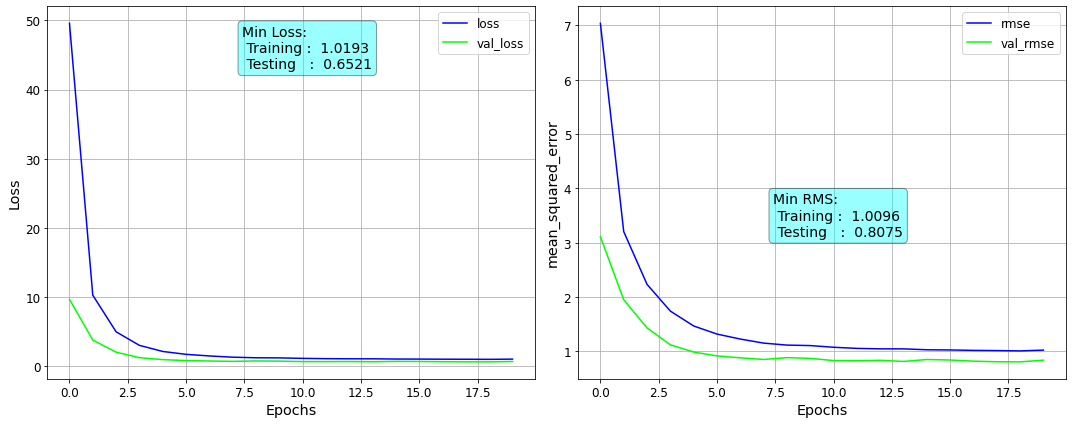

In [28]:
hist_df = pd.DataFrame(history.history)
hist_df = hist_df.rename({'root_mean_squared_error': 'rmse', 'val_root_mean_squared_error' : 'val_rmse'}, axis=1)


fn_plot_hist(hist_df)

In [29]:
# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.append(y_train_pred, y_test_pred)

26/26 [==============================] - 0s 4ms/step


In [30]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

,datetime,temp,pred
24,2006-01-01,5.422222,4.676320
48,2006-01-02,1.694444,1.558326
72,2006-01-03,2.200000,1.832092
96,2006-01-04,1.666667,1.778689
120,2006-01-05,1.805556,2.214251


In [31]:
res_df.tail()

,datetime,temp
96336,2016-12-27 02:00:00+00:00,-1.627778
96360,2016-12-28 02:00:00+00:00,-1.677778
96384,2016-12-29 02:00:00+00:00,-1.727778
96408,2016-12-30 02:00:00+00:00,-1.777778
96432,2016-12-31 02:00:00+00:00,-1.822222


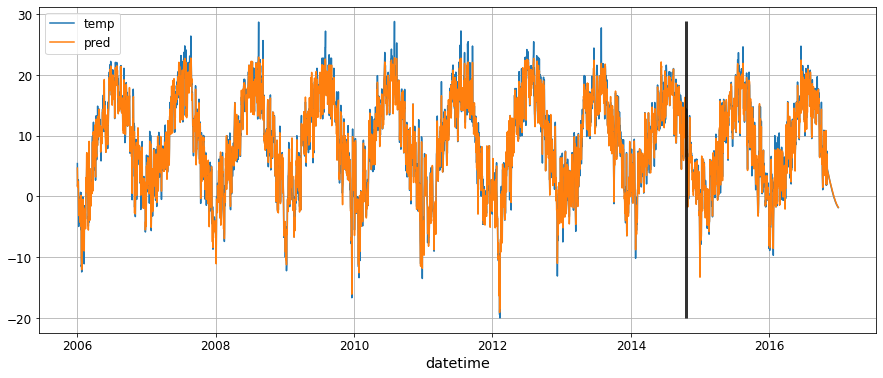

In [33]:
fig, ax = plt.subplots(figsize = (15,6))

res_df.plot(x='datetime', y=['temp','pred'], ax = ax);

ax.vlines(res_df.iloc[X_train.shape[0]]['datetime'], 
          res_df['temp'].min(), 
          res_df['temp'].max(), color = 'k', 
          linewidth=3.0, zorder=10, alpha =0.8)

ax.grid()